In [1]:
# if you are using Colab 
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# load training and test sets from drive
path_to_train = '/content/drive/MyDrive/AMATH/MNIST_training_set.npy'; 
path_to_test = '/content/drive/MyDrive/AMATH/MNIST_test_set.npy'

d_train = np.load(path_to_train, allow_pickle=True); 
d_test = np.load(path_to_test, allow_pickle=True)

# Uncomment to load sets from disk (for TA or whoever grading)
# d_train = np.load('./MNIST_training_set.npy', allow_pickle=True).item()
# d_test = np.load('./MNIST_test_set.npy', allow_pickle=True).item() 


In [3]:
X_train = d_train.item().get('features'); Y_train = d_train.item().get('labels')
print(X_train.shape); print(Y_train.shape)

X_test = d_test.item().get('features'); Y_test = d_test.item().get('labels')
print(X_test.shape); print(Y_test.shape)

(2000, 256)
(2000,)
(500, 256)
(500,)


[1. 1. 1. 6. 0. 4. 9. 9. 3. 7. 1. 8. 3. 8. 7. 4. 3. 4. 0. 2. 5. 6. 2. 6.
 0. 0. 9. 0. 8. 1. 2. 7. 9. 7. 4. 5. 2. 4. 9. 3. 3. 1. 8. 8. 6. 4. 6. 3.
 0. 3. 1. 1. 7. 8. 9. 4. 0. 7. 7. 0. 0. 7. 2. 6.]


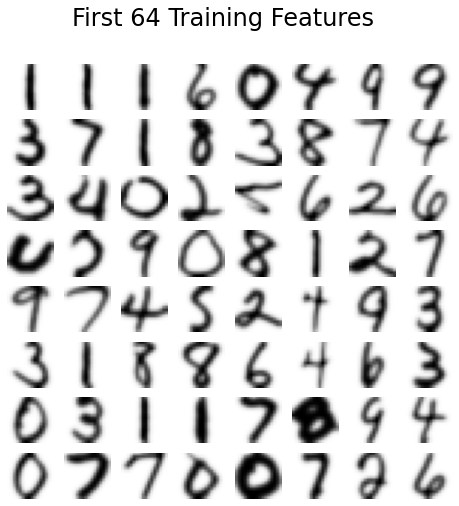

In [4]:
# Plot some of the training sets 

def plot_digits(XX, N, title):
    """Small helper function to plot N**2 digits."""
    fig, ax = plt.subplots(N, N, figsize=(8, 8))
    for i in range(N):
      for j in range(N):
        ax[i,j].imshow(XX[(N)*i+j,:].reshape((16, 16)), cmap="Greys")
        ax[i,j].axis("off")
    fig.suptitle(title, fontsize=24)

plot_digits(X_train, 8, "First 64 Training Features" )

print(Y_train[0:8**2])

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
import math

In [6]:
'''
FUNCTIONS FOUND IN hw2_jj_functions.py
'''
def grabDigits(X_data, y_data, digits=None):
# write a function that extracts the features and labels of the digits 1 and 8 from the training dataset
    digit_locations = np.where(np.isin(y_data, digits))[0] # Find rows of matching entries
    y_new = y_data[digit_locations] ; X_new = X_data[digit_locations, :] # data
    
    return X_new, y_new

def reduceData(X, N):
# project X(1,8) on the first 16 PCA modes of 𝑋train computed in step 1
    pca_model = PCA(); pca_model.fit(X)
    all_comp = np.copy(pca_model.components_) # copies components
    X_pca = pca_model.transform(X) # transforms data
    X_reduced = np.dot(X - pca_model.mean_, pca_model.components_[:N].T) # reduce data to n components
    pca_model.components_[N:] = 0 ; pca_model.components_ = all_comp # only save n components and resets them
    
    return X_reduced

def ridgeModel(train_X, test_X, train_Y, test_Y, N, alpha=None, digits=None):
    # make training and test datasets
    redX_train = reduceData(train_X,N); redX_test = reduceData(test_X, N);
    A_train, y_train = grabDigits(redX_train, train_Y,  digits=digits); b_train = np.where(y_train == digits[0], -1, 1) # assign -1 to first digit and +1 to second
    A_test, y_test = grabDigits(redX_test, test_Y,  digits=digits); b_test = np.where(y_test == digits[0], -1, 1)
    # ridge regression model
    ridge = Ridge(alpha=alpha, random_state=None); ridge.fit(A_train, b_train) # Fit on training data
    A_train, b_train = shuffle(A_train, b_train, random_state=None) # Shuffle after fitting
    # predict on train and test data
    y_train_pred = ridge.predict(A_train) ; y_test_pred = ridge.predict(A_test)
    # do MSE calcs
    train_mse = mean_squared_error(y_train_pred, b_train) # train MSE
    test_mse = mean_squared_error(y_test_pred, b_test) # test MSE
    y_train_pred_binary = np.where(y_train_pred <= 0, -1, 1) # Convert to classes
    y_test_pred_binary = np.where(y_test_pred <= 0, -1, 1) # Convert to absolutes
    train_correct = np.count_nonzero(y_train_pred_binary == b_train) / len(y_train_pred) # % correct train
    test_correct = np.count_nonzero(y_test_pred_binary == b_test) / len(y_test_pred) # % correct test

    return train_mse, train_correct,  test_mse, test_correct, A_test, y_test, y_test_pred, A_test, b_test

def numMisclassified(rr):
    # how many misclassified samples in the test set.
    # adopted from https://drbeane.github.io/_pages/courses/dsci390/06%20-%20MNIST%20Dataset.html
    sel = rr[6] != rr[8]; n_mc = np.sum(sel) # number misclassified
    X_mc = rr[4][sel,:]; y_mc = rr[8][sel]; yp_mc = rr[6][sel]
    idx = np.argsort(y_mc); X_mc = X_mc[idx,:]; y_mc = y_mc[idx]; yp_mc = yp_mc[idx]
    rows = math.ceil(n_mc / 6)

    return n_mc

PCA Model

In [7]:
# PCA Model, initialize and fit
pca = PCA(); pca.fit(X_train);

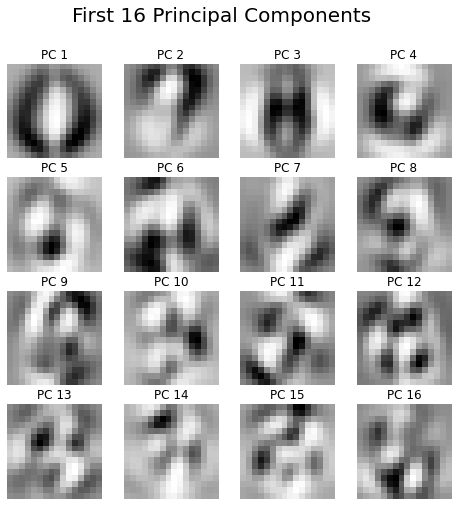

In [8]:
# 1. first 16 modes
first_16 = pca.components_[:16] # Extract the first modes
fig, ax = plt.subplots(4, 4, figsize=(8,8)) # Four x four space
for i in range(4):
    for j in range(4):
        ax[i, j].imshow(first_16[(4 * i) + j, :].reshape((16, 16)), cmap="Greys") # Plot component
        ax[i, j].axis('off')
        ax[i, j].set_title('PC ' + str((4 * i) + j + 1)) # Set title
fig.suptitle('First 16 Principal Components', fontsize=20)
plt.show()

How many PCA modes?

In [9]:
# Including 60%, 80%, 90% of variance. Return the number of Components which will have total variances of 60, 80, 90%.
vars = [.6, .8,.9]
for v in vars:
  pca = PCA(v); pca.fit(X_train); transformed_train_ = pca.transform(X_train)
  print('PCs for', v, ':', pca.n_components_)

PCs for 0.6 : 6
PCs for 0.8 : 13
PCs for 0.9 : 23


In [10]:
# Try on Standardized data
scaler = StandardScaler(); scaler.fit(X_train) #fit only on training set
#Apply transformation on training set
train_T = scaler.transform(X_train);
# Same for standardized data
for v in vars:
  pca = PCA(v); pca.fit(train_T); transformed_train_ = pca.transform(train_T)
  print('PCs for', v,':', pca.n_components_)

PCs for 0.6 : 7
PCs for 0.8 : 15
PCs for 0.9 : 26


PCs for 0.6 : 3
PCs for 0.8 : 7
PCs for 0.9 : 14


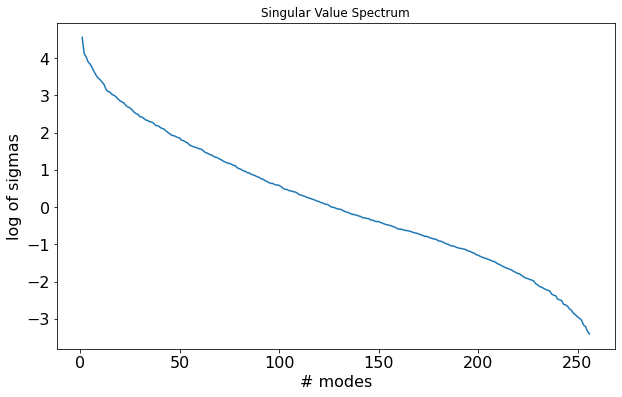

In [14]:
# Try with Frob Norm
pca = PCA(); pca.fit(X_train);
frob_norms = np.cumsum(pca.singular_values_**2)**0.5 / np.sum(pca.singular_values_**2)**0.5
for v in vars:
  fn = np.where(frob_norms >= v)[0].min() + 1
  print('PCs for', v,':', fn)

# singular value spect
plt.figure(figsize=(10, 6))
idxs = np.arange(1, len(pca.singular_values_) + 1)
plt.plot(idxs, np.log(pca.singular_values_))
plt.ylabel('log of sigmas', fontsize=16)
plt.xlabel('# modes', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Singular Value Spectrum')
plt.show()

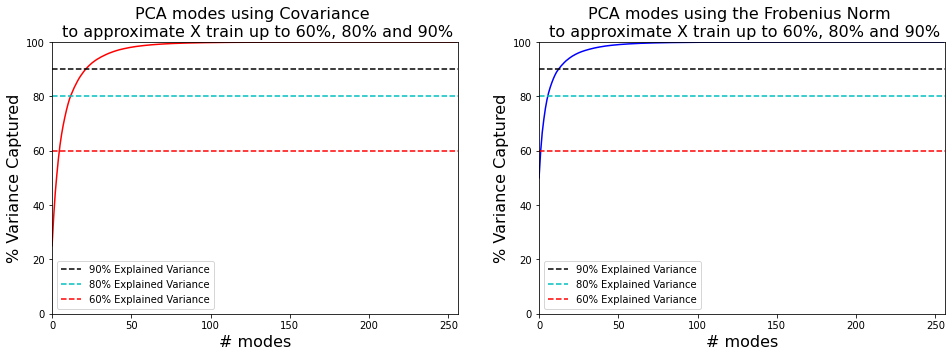

In [18]:
# reinitialize
pca = PCA() ; pca.fit(X_train);

# plot graphs
fig, ax = plt.subplots(1, 2, figsize=(16,5)) # Four x four space

# cum sum
ax[0].plot(np.cumsum(pca.explained_variance_ratio_*100), 'r')
ax[0].set_xlim(xmin=0.0, xmax=256); ax[0].set_ylim(ymin=0.0, ymax=100)
ax[0].set_title('PCA modes using Covariance \n to approximate X train up to 60%, 80% and 90%', fontsize=16)
ax[0].set_xlabel('# modes', fontsize=16); ax[0].set_ylabel('% Variance Captured', fontsize=16);
ax[0].axhline(y = 90, color='k', linestyle='--', label = '90% Explained Variance'); 
ax[0].axhline(y = 80, color='c', linestyle='--', label = '80% Explained Variance'); 
ax[0].axhline(y = 60, color='r', linestyle='--', label = '60% Explained Variance')
ax[0].legend(loc='best')

# Frob norm
ax[1].plot(frob_norms*100, 'b')
ax[1].set_xlim(xmin=0.0, xmax=256); ax[1].set_ylim(ymax = 100, ymin = 0)
ax[1].set_title('PCA modes using the Frobenius Norm \n to approximate X train up to 60%, 80% and 90%', fontsize=16)
ax[1].set_xlabel('# modes', fontsize=16); ax[1].set_ylabel('% Variance Captured', fontsize=16);
ax[1].axhline(y = 90, color='k', linestyle='--', label = '90% Explained Variance'); 
ax[1].axhline(y = 80, color='c', linestyle='--', label = '80% Explained Variance'); 
ax[1].axhline(y = 60, color='r', linestyle='--', label = '60% Explained Variance')
ax[1].legend(loc='best')

plt.show()

Train Classifier

In [19]:
# Model performance on digits 1,8
rr18 = ridgeModel(X_train, X_test, Y_train, Y_test, 16, alpha=0.01, digits=[1,8]); 
print('Train MSE:',rr18[0])
print('Train Percent Correct:',rr18[1])
print('Test MSE:',rr18[2]) 
print('Test Correct:',rr18[3])

Train MSE: 0.07459618304093601
Train Percent Correct: 0.9956043956043956
Test MSE: 0.13499079416903723
Test Correct: 0.9791666666666666


In [20]:
# Use your code from step 3 to train classifiers for the pairs of digits (3,8) and (2,7) and report the training and test MSE’s
rr38 = ridgeModel(X_train, X_test, Y_train, Y_test, 16, alpha=0.01, digits=[3,8]); print(rr38[0:4])
rr27 = ridgeModel(X_train, X_test, Y_train, Y_test, 16, alpha=0.01, digits=[2,7]); print(rr27[0:4])

(0.18039726996201041, 0.9857549857549858, 0.5700316214831447, 0.8333333333333334)
(0.09177827838810289, 0.9943019943019943, 0.37432102707527837, 0.9693877551020408)


<Figure size 1440x1440 with 0 Axes>

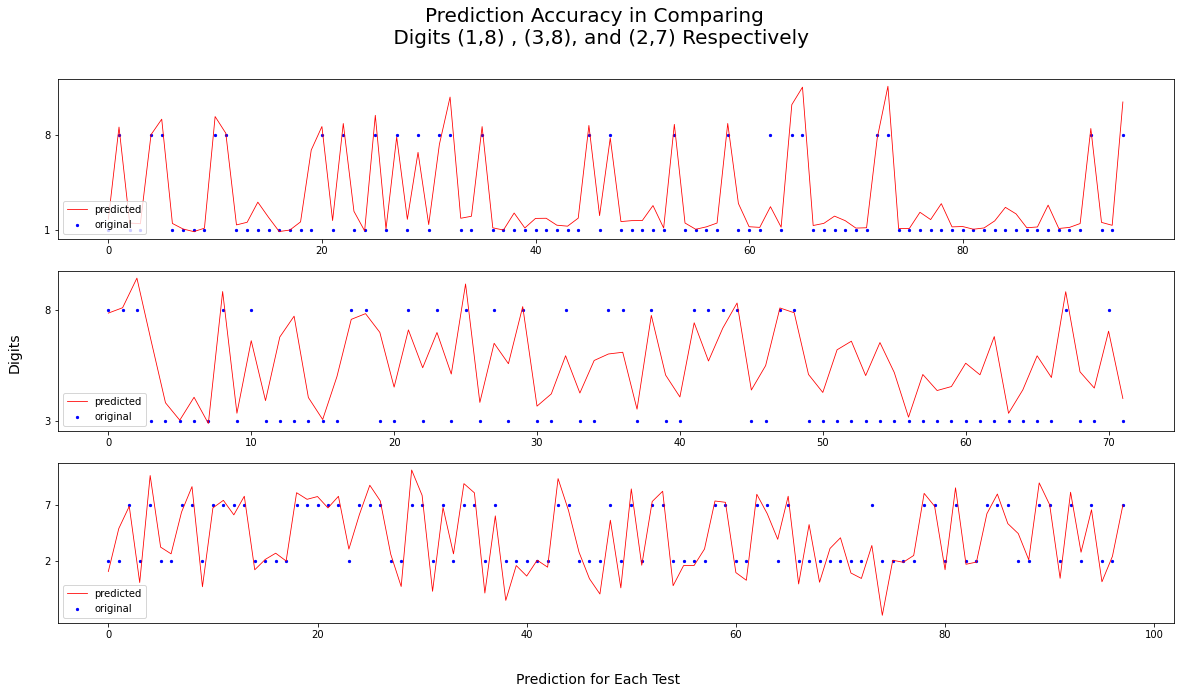

In [22]:
# visualize some stuff
plt.figure(figsize=(20,20))
fig, ax = plt.subplots(3, 1, figsize=(20, 10))
x_18 = range(len(rr18[7])); x_38 = range(len(rr38[7])); x_27 = range(len(rr27[7]))

fig.text(0.5, 0.04, 'Prediction for Each Test', ha='center', fontsize = 14)
fig.text(0.09, 0.5, 'Digits', va='center', rotation='vertical', fontsize = 14)
fig.suptitle('Prediction Accuracy in Comparing \n Digits (1,8) , (3,8), and (2,7) Respectively',  fontsize=20)

#Digits 1 v 8
ax[0].scatter(x_18,rr18[8], s=5, color="blue", label="original")
ax[0].plot(x_18, rr18[6], lw=0.8, color="red", label="predicted")
ax[0].set_yticks(np.arange(-1,1.1,2))
ax[0].set_yticklabels(labels=['1','8'])
ax[0].legend(loc=3)

#Digits 3 v 8
ax[1].scatter(x_38,rr38[8], s=5, color="blue", label="original")
ax[1].plot(x_38, rr38[6], lw=0.8, color="red", label="predicted")
ax[1].set_yticks(np.arange(-1,1.1,2))
ax[1].set_yticklabels(labels=['3','8'])
ax[1].legend(loc=3)

#Digits 2 v 7
ax[2].scatter(x_27,rr27[8], s=5, color="blue", label="original")
ax[2].plot(x_27, rr27[6], lw=0.8, color="red", label="predicted")
ax[2].set_yticks(np.arange(-1,1.1,2))
ax[2].set_yticklabels(labels=['2','7'])
ax[2].legend(loc=3)

plt.show()